In [418]:
import pandas as pd

In [419]:
# Load the saved datasets
final_fire_data = pd.read_csv("final_fire_data.csv")
demographic_data = pd.read_csv("demographic_data.csv")


In [420]:
# Convert ZIP code to string and pad if needed
final_fire_data["ZIP_CODE"] = final_fire_data["ZIP_CODE"].astype(str).str.zfill(5)
demographic_data["ZIP_CODE"] = demographic_data["ZIP_CODE"].astype(str).str.zfill(5)

# Convert year to int (if needed)
final_fire_data["YEAR_"] = final_fire_data["YEAR_"].astype(int)
demographic_data["YEAR"] = demographic_data["YEAR"].astype(int)


In [421]:
final_fire_data.shape

(1917, 7)

In [422]:
merged_data = pd.merge(
    demographic_data,
    final_fire_data,
    left_on=["ZIP_CODE", "YEAR"],
    right_on=["ZIP_CODE", "YEAR_"],
    how="left",
    indicator=True
)

merged_data["_merge"].value_counts()

_merge
left_only     11236
both           1831
right_only        0
Name: count, dtype: int64

In [423]:
unmatched_zips = final_fire_data.loc[
    ~final_fire_data["ZIP_CODE"].isin(demographic_data["ZIP_CODE"].unique()),
    "ZIP_CODE"
].value_counts()

unmatched_zips # 2 zips aren't included in demographic dataset (1917 - 1915)
# those 2 ZIPs’ rows in the fire data are dropped in the final merge result, because we're joining from demographic ZIPs only (left join), and those 2 ZIPs don’t exist there.

ZIP_CODE
93633    7
95364    6
92055    5
91980    3
95679    3
95915    3
93262    2
95903    2
92096    1
92304    1
93042    1
93437    1
95972    1
Name: count, dtype: int64

In [424]:
# Create a flag column for fire exposure
# 0 means no
# 1 means yes
merged_data["FIRE_EXPOSED"] = (merged_data["_merge"] == "both").astype(int)



In [425]:
merged_data.shape

(13067, 22)

In [426]:
#######  Create Target Value: PCT_PRICE_CHANGE ###########

# Step 1: Sort by ZIP and Year
merged_data = merged_data.sort_values(by=["ZIP_CODE", "YEAR"])

# Step 2: Compute next year’s median home value per ZIP
merged_data["NEXT_YEAR_PRICE"] = (
    merged_data.groupby("ZIP_CODE")["PRICE"].shift(-1)
)

# Step 3: Compute price change
merged_data["PRICE_CHANGE"] = (
    merged_data["NEXT_YEAR_PRICE"] - merged_data["PRICE"]
)

# Step 4: Compute percent price change
merged_data["PCT_PRICE_CHANGE (%)"] = (
    merged_data["PRICE_CHANGE"] / merged_data["PRICE"]
) * 100

# Step 5: Drop rows where the percent change can't be calculated (e.g., final year)
merged_data = merged_data.dropna(subset=["PCT_PRICE_CHANGE (%)"])



In [427]:
col = ["PRICE", "NEXT_YEAR_PRICE", "PRICE_CHANGE", "PCT_PRICE_CHANGE (%)"]
merged_data[col].head(4)

,PRICE,NEXT_YEAR_PRICE,PRICE_CHANGE,PCT_PRICE_CHANGE (%)
733,263100.00,249600.00,-13500.00,-5.13
2778,249600.00,241800.00,-7800.00,-3.12
4268,241800.00,258500.00,16700.00,6.91
6152,258500.00,272200.00,13700.00,5.30


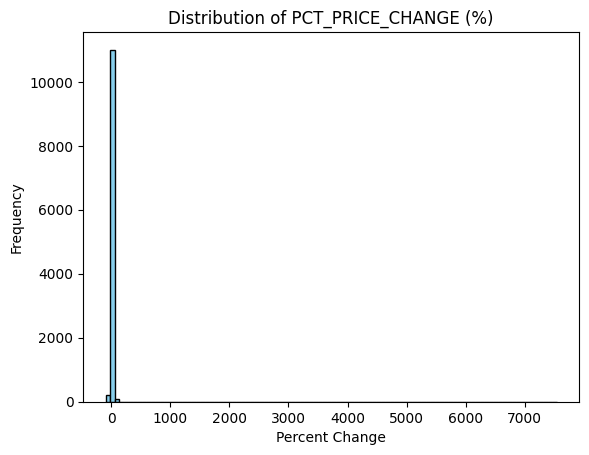

In [428]:
import matplotlib.pyplot as plt

# Histogram of PCT_PRICE_CHANGE (%) with all values
plt.hist(merged_data["PCT_PRICE_CHANGE (%)"], bins=100, color='skyblue', edgecolor='black')
plt.title("Distribution of PCT_PRICE_CHANGE (%)")
plt.xlabel("Percent Change")
plt.ylabel("Frequency")
plt.show()


In [429]:
# Show the top 5 highest % changes
print("Largest % increases:")
print(merged_data["PCT_PRICE_CHANGE (%)"].sort_values(ascending=False).head())

# Show the bottom 5 lowest % changes
print("\nLargest % decreases:")
print(merged_data["PCT_PRICE_CHANGE (%)"].sort_values().head())


Largest % increases:
1090   7539.76
3851    580.44
1211    473.94
3490    377.46
1210    256.04
Name: PCT_PRICE_CHANGE (%), dtype: float64

Largest % decreases:
7279   -93.55
6480   -89.59
3040   -87.13
419    -83.54
2711   -80.34
Name: PCT_PRICE_CHANGE (%), dtype: float64


In [430]:
# Define a reasonable threshold (e.g., anything > 200% or < -200%)
threshold = 200

# Subset rows where the percent change is extreme
extreme_outliers = merged_data[
    (merged_data["PCT_PRICE_CHANGE (%)"] > threshold) |
    (merged_data["PCT_PRICE_CHANGE (%)"] < -threshold)
]

# Show relevant columns
extreme_outliers = extreme_outliers[["ZIP_CODE", "YEAR", "PRICE", "NEXT_YEAR_PRICE", "PCT_PRICE_CHANGE (%)"]]

# Display

pd.set_option("display.float_format", lambda x: f"{x:.2f}")
extreme_outliers_sorted = extreme_outliers.sort_values("PCT_PRICE_CHANGE (%)", ascending=False)
extreme_outliers_sorted.shape

#extreme_outliers_sorted

(10, 5)

In [431]:
# Remove extreme outliers from the full merged dataset
threshold = 200
mask_extreme = (merged_data["PCT_PRICE_CHANGE (%)"].abs() > threshold)
merged_data= merged_data[~mask_extreme].copy()


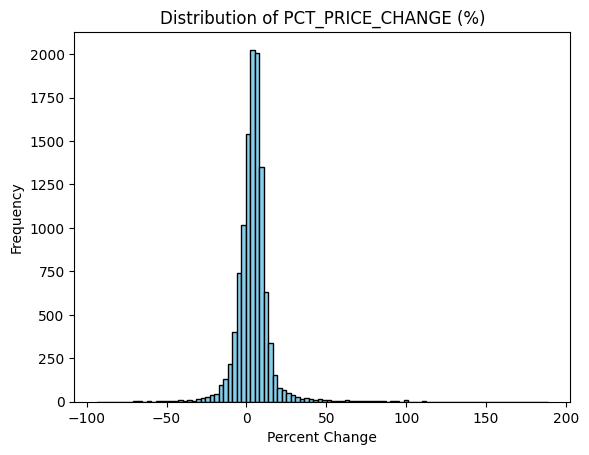

In [432]:
import matplotlib.pyplot as plt

# Histogram of PCT_PRICE_CHANGE (%) with all values
plt.hist(merged_data["PCT_PRICE_CHANGE (%)"], bins=100, color='skyblue', edgecolor='black')
plt.title("Distribution of PCT_PRICE_CHANGE (%)")
plt.xlabel("Percent Change")
plt.ylabel("Frequency")
plt.show()


In [433]:
# Fill 
merged_data.shape # we lost 1800 ish rows

(11293, 25)

In [434]:
# Drop merge indicator and other useless columns
col_drop = ["_merge", "YEAR_"]
merged_data.drop(columns=col_drop, inplace=True)
# Reset index for modeling
merged_data.reset_index(drop=True, inplace=True)

merged_data.head()

,Median_Household_Income,Total_Population,PRICE,Avg_Household_Size,Gini_Index,ZIP_CODE,YEAR,Employment_Rate,Below_Poverty_Rate,Rate_College_or_Higher,...,Asian_Portion,NUM_FIRES,TOTAL_ACRES_BURNED_IN_ZIP,AVG_FIRE_DURATION_DAYS,MAX_PCT_ZIP_BURNED,ANY_MAJOR_FIRE,FIRE_EXPOSED,NEXT_YEAR_PRICE,PRICE_CHANGE,PCT_PRICE_CHANGE (%)
0,35658.00,54480,263100.00,4.24,0.41,90001,2012,89.37,30.63,16.68,...,0.15,NaN,NaN,NaN,NaN,NaN,0,249600.00,-13500.00,-5.13
1,35097.00,54760,249600.00,4.23,0.41,90001,2013,87.75,32.06,17.06,...,0.14,NaN,NaN,NaN,NaN,NaN,0,241800.00,-7800.00,-3.12
2,34050.00,56314,241800.00,4.22,0.42,90001,2014,87.02,33.64,18.10,...,0.15,NaN,NaN,NaN,NaN,NaN,0,258500.00,16700.00,6.91
3,33887.00,57227,258500.00,4.25,0.42,90001,2015,87.33,32.52,17.48,...,0.17,NaN,NaN,NaN,NaN,NaN,0,272200.00,13700.00,5.30
4,34323.00,57942,272200.00,4.26,0.42,90001,2016,87.72,32.68,18.82,...,0.17,NaN,NaN,NaN,NaN,NaN,0,305500.00,33300.00,12.23


In [435]:
########################################### Adding the time series features and burn features to improve model ########################################


# Adding features

# Rolling averages (commenting them out cause we lose to much data)
# Rolling average of price change over the last 1 year (excluding current)
merged_data["ROLLING_1yr_PRICE_CHANGE"] = merged_data.groupby("ZIP_CODE")["PCT_PRICE_CHANGE (%)"].shift(1).rolling(1).mean()
# Rolling average of price change over the last 2 years (excluding current): Smooths short-term volatility to identify trends
#df["ROLLING_2yr_PRICE_CHANGE"] = df.groupby("ZipCode")["PCT_PRICE_CHANGE (%)"].shift(1).rolling(2).mean() we lose too much data

# Lag price-related features
merged_data['HOME_PRICE_LAG1'] = merged_data.groupby('ZIP_CODE')['PRICE'].shift(1)
merged_data['PRICE_CHANGE_LAG1'] = merged_data.groupby('ZIP_CODE')['PRICE_CHANGE'].shift(1)
merged_data['PRICE_CHANGE_DIFF'] = merged_data['PRICE_CHANGE'] - merged_data['PRICE_CHANGE_LAG1']

# What it is: Max % of ZIP burned from the previous year.
# Why: Fires may have a lagged effect on market prices — impact might show up the year after.
merged_data['PREV_MAX_PCT_ZIP_BURNED'] = merged_data.groupby('ZIP_CODE')['MAX_PCT_ZIP_BURNED'].shift(1)

# Post-fire year: fire happened in the previous year
merged_data['FIRE_LAST_YEAR'] = merged_data.groupby('ZIP_CODE')['ANY_MAJOR_FIRE'].shift(1).fillna(0).astype(int)

# Fire shock indicator: 1 if ZIP had 2+ fires in a year (unusually high fire activity).
# Based on domain logic and histogram — most ZIP-years have 0–1 fire, so 2+ is a meaningful threshold.
merged_data['FIRE_SHOCK'] = (merged_data['NUM_FIRES'] >= 2).astype(int)

In [436]:
merged_data.head(10)

,Median_Household_Income,Total_Population,PRICE,Avg_Household_Size,Gini_Index,ZIP_CODE,YEAR,Employment_Rate,Below_Poverty_Rate,Rate_College_or_Higher,...,NEXT_YEAR_PRICE,PRICE_CHANGE,PCT_PRICE_CHANGE (%),ROLLING_1yr_PRICE_CHANGE,HOME_PRICE_LAG1,PRICE_CHANGE_LAG1,PRICE_CHANGE_DIFF,PREV_MAX_PCT_ZIP_BURNED,FIRE_LAST_YEAR,FIRE_SHOCK
0,35658.00,54480,263100.00,4.24,0.41,90001,2012,89.37,30.63,16.68,...,249600.00,-13500.00,-5.13,NaN,NaN,NaN,NaN,NaN,0,0
1,35097.00,54760,249600.00,4.23,0.41,90001,2013,87.75,32.06,17.06,...,241800.00,-7800.00,-3.12,-5.13,263100.00,-13500.00,5700.00,NaN,0,0
2,34050.00,56314,241800.00,4.22,0.42,90001,2014,87.02,33.64,18.10,...,258500.00,16700.00,6.91,-3.12,249600.00,-7800.00,24500.00,NaN,0,0
3,33887.00,57227,258500.00,4.25,0.42,90001,2015,87.33,32.52,17.48,...,272200.00,13700.00,5.30,6.91,241800.00,16700.00,-3000.00,NaN,0,0
4,34323.00,57942,272200.00,4.26,0.42,90001,2016,87.72,32.68,18.82,...,305500.00,33300.00,12.23,5.30,258500.00,13700.00,19600.00,NaN,0,0
5,35660.00,58738,305500.00,4.25,0.42,90001,2017,88.81,31.85,19.52,...,336100.00,30600.00,10.02,12.23,272200.00,33300.00,-2700.00,NaN,0,0
6,38521.00,58975,336100.00,4.26,0.42,90001,2018,90.33,28.75,20.54,...,359000.00,22900.00,6.81,10.02,305500.00,30600.00,-7700.00,NaN,0,0
7,32299.00,48613,238300.00,4.18,0.46,90002,2012,89.95,32.54,23.46,...,216100.00,-22200.00,-9.32,NaN,NaN,NaN,NaN,NaN,0,0
8,31258.00,49475,216100.00,4.23,0.45,90002,2013,86.44,34.75,24.09,...,218800.00,2700.00,1.25,-9.32,238300.00,-22200.00,24900.00,NaN,0,0
9,30214.00,50098,218800.00,4.21,0.45,90002,2014,85.68,36.33,22.33,...,227200.00,8400.00,3.84,1.25,216100.00,2700.00,5700.00,NaN,0,0


In [437]:
merged_data.columns

Index(['Median_Household_Income', 'Total_Population', 'PRICE',
       'Avg_Household_Size', 'Gini_Index', 'ZIP_CODE', 'YEAR',
       'Employment_Rate', 'Below_Poverty_Rate', 'Rate_College_or_Higher',
       'Black_Portion', 'White_Portion',
       'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
       'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS',
       'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED',
       'NEXT_YEAR_PRICE', 'PRICE_CHANGE', 'PCT_PRICE_CHANGE (%)',
       'ROLLING_1yr_PRICE_CHANGE', 'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1',
       'PRICE_CHANGE_DIFF', 'PREV_MAX_PCT_ZIP_BURNED', 'FIRE_LAST_YEAR',
       'FIRE_SHOCK'],
      dtype='object')

In [438]:
#  Replace wildfire NAs with meaningful values: replace it with 0 cause it simply never happened

# Define fire-related columns where NaN should be treated as 0 (no exposure)
fire_cols = [
    'NUM_FIRES',
    'TOTAL_ACRES_BURNED_IN_ZIP',
    'AVG_FIRE_DURATION_DAYS',
    'PREV_MAX_PCT_ZIP_BURNED',
    'ANY_MAJOR_FIRE',
    'FIRE_LAST_YEAR',
    "MAX_PCT_ZIP_BURNED"
]

# Replace NaNs with 0 for those columns
merged_data[fire_cols] = merged_data[fire_cols].fillna(0)

merged_data.head()

,Median_Household_Income,Total_Population,PRICE,Avg_Household_Size,Gini_Index,ZIP_CODE,YEAR,Employment_Rate,Below_Poverty_Rate,Rate_College_or_Higher,...,NEXT_YEAR_PRICE,PRICE_CHANGE,PCT_PRICE_CHANGE (%),ROLLING_1yr_PRICE_CHANGE,HOME_PRICE_LAG1,PRICE_CHANGE_LAG1,PRICE_CHANGE_DIFF,PREV_MAX_PCT_ZIP_BURNED,FIRE_LAST_YEAR,FIRE_SHOCK
0,35658.00,54480,263100.00,4.24,0.41,90001,2012,89.37,30.63,16.68,...,249600.00,-13500.00,-5.13,NaN,NaN,NaN,NaN,0.00,0,0
1,35097.00,54760,249600.00,4.23,0.41,90001,2013,87.75,32.06,17.06,...,241800.00,-7800.00,-3.12,-5.13,263100.00,-13500.00,5700.00,0.00,0,0
2,34050.00,56314,241800.00,4.22,0.42,90001,2014,87.02,33.64,18.10,...,258500.00,16700.00,6.91,-3.12,249600.00,-7800.00,24500.00,0.00,0,0
3,33887.00,57227,258500.00,4.25,0.42,90001,2015,87.33,32.52,17.48,...,272200.00,13700.00,5.30,6.91,241800.00,16700.00,-3000.00,0.00,0,0
4,34323.00,57942,272200.00,4.26,0.42,90001,2016,87.72,32.68,18.82,...,305500.00,33300.00,12.23,5.30,258500.00,13700.00,19600.00,0.00,0,0


In [439]:
merged_data.isna().sum()

Median_Household_Income                        26
Total_Population                                0
PRICE                                           0
Avg_Household_Size                              0
Gini_Index                                      0
ZIP_CODE                                        0
YEAR                                            0
Employment_Rate                                 7
Below_Poverty_Rate                              0
Rate_College_or_Higher                          0
Black_Portion                                   0
White_Portion                                   0
American_Indian_and_Alaska_Native_Portion       0
Asian_Portion                                   0
NUM_FIRES                                       0
TOTAL_ACRES_BURNED_IN_ZIP                       0
AVG_FIRE_DURATION_DAYS                          0
MAX_PCT_ZIP_BURNED                              0
ANY_MAJOR_FIRE                                  0
FIRE_EXPOSED                                    0


In [440]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11293 entries, 0 to 11292
Data columns (total 30 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Median_Household_Income                    11267 non-null  float64
 1   Total_Population                           11293 non-null  int64  
 2   PRICE                                      11293 non-null  float64
 3   Avg_Household_Size                         11293 non-null  float64
 4   Gini_Index                                 11293 non-null  float64
 5   ZIP_CODE                                   11293 non-null  object 
 6   YEAR                                       11293 non-null  int64  
 7   Employment_Rate                            11286 non-null  float64
 8   Below_Poverty_Rate                         11293 non-null  float64
 9   Rate_College_or_Higher                     11293 non-null  float64
 10  Black_Portion         

In [441]:
# FINAL XGBOOST DATA
Xgboost_data = merged_data.copy()

# Save cleaned fire data
Xgboost_data.to_csv("xgboost_data.csv", index=False)
